# FSK Demodulation

I want to be able to write a software FSK (Frequency Shift Key) Modem. First, I'll try to figure out the Demodulation step...

## Zero-crossing detection

The simplest approach is zero-crossing detection - just see how often the sign changes to determine the frequency in a particular point.


In [1]:
# Imports and boilerplate to make graphs look better
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy
import wave
from IPython.display import Audio

def setup_graph(title='', x_label='', y_label='', fig_size=None):
    fig = plt.figure()
    if fig_size != None:
        fig.set_size_inches(fig_size[0], fig_size[1])
    ax = fig.add_subplot(111)
    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)

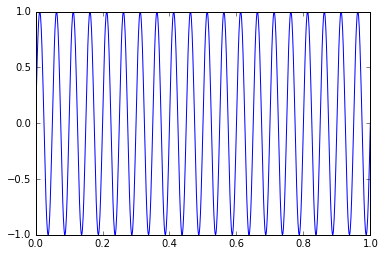

In [2]:
samp_rate = 1000
len_in_sec = 1
carrier_freq = 20  # Hz
t = np.linspace(0, 1, samp_rate * len_in_sec)
carrier = 1*np.sin(carrier_freq * 2 * np.pi * t)
plt.plot(t, carrier)

In [3]:
zero_crossings = np.where(np.diff(np.sign(carrier)))[0]

In [4]:
zero_crossings

array([  0,  24,  49,  74,  99, 124, 149, 174, 199, 224, 249, 274, 299,
       324, 349, 374, 399, 424, 449, 474, 499, 524, 549, 574, 599, 624,
       649, 674, 699, 724, 749, 774, 799, 824, 849, 874, 899, 924, 949, 974])

In [5]:
len(zero_crossings)

40

In [6]:
# Note that in a single wave cycle, there will be 2 zero crossings
frequency_detected = len(zero_crossings) / 2
frequency_detected

20.0

## Multiplying by frequencies

To try to determine the frequency, we can just take the dot product of a number of prospective frequencies, and see which has the largest dot product, which should correspond to the closest approximation of the frequency.

In [22]:
hz_10 = 1*np.sin(10 * 2 * np.pi * t)
hz_20 = 1*np.sin(20 * 2 * np.pi * t)
hz_30 = 1*np.sin(30 * 2 * np.pi * t)

In [23]:
[np.dot(carrier, hz_10), np.dot(carrier, hz_20), np.dot(carrier, hz_30)]

[3.4227828904498381e-14, 499.50000000000006, -5.1039034110189618e-14]

#### Note that the 20hz dot product is way larger than the 10Hz or 30Hz wave

It's worth noting, however, that if the frequency is just a bit off, the dot product is still near zero, so there's not a lot of room for error in terms of the frequency with this approach. Only 0.5Hz off has a near-zero dot product.

In [26]:
np.dot(carrier, 1*np.sin(19.5 * 2 * np.pi * t))

-5.3083232254280688e-13

In [29]:
np.dot(carrier, 1*np.sin(19.6 * 2 * np.pi * t))

117.99304872790121

In [30]:
np.dot(carrier, 1*np.sin(19.7 * 2 * np.pi * t))

253.91777912175343

In [31]:
np.dot(carrier, 1*np.sin(19.8 * 2 * np.pi * t))

379.9246442915134

In [32]:
np.dot(carrier, 1*np.sin(19.9 * 2 * np.pi * t))

468.44184940090764

I just want to double-check that harmonics don't have large dot products

In [56]:
np.dot(carrier, 1*np.sin(40 * 2 * np.pi * t))

-1.2802259252708836e-15

### Relationship between frequency difference and dot product

Out of curiosity, let's graph the <a href="#frequency_diff_to_dot_product">relationship</a> between the difference in the frequencies and the dot product

In [52]:
def dot_between_freqs(f1, f2):
    t = np.linspace(0, 1, samp_rate * len_in_sec)
    f1_samples = 1*np.sin(f1 * 2 * np.pi * t)
    f2_samples = 1*np.sin(f2 * 2 * np.pi * t)
    return np.dot(f1_samples, f2_samples)

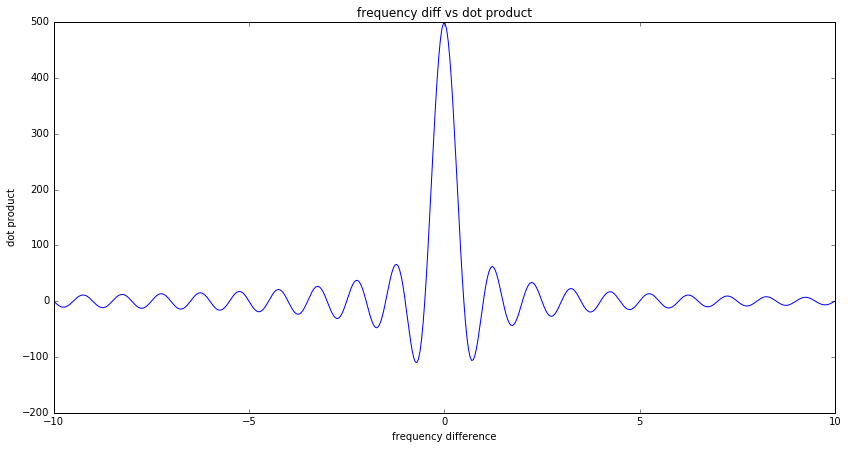

In [63]:
center_freq = 20
frequency_diffs = np.linspace(-10, 10, 500)
dots = [dot_between_freqs(center_freq, center_freq+d) for d in frequency_diffs]
setup_graph(title='frequency diff vs dot product', x_label='frequency difference', y_label='dot product', fig_size=(14,7))
plt.plot(frequency_diffs, dots)

Interesting! So it looks like a reflected damped sine wave. Now, does the variation in the dot product change based on absolute deviation from the center frequency, or is it based on percentage? Let's try a higher frequency with the same deviations...

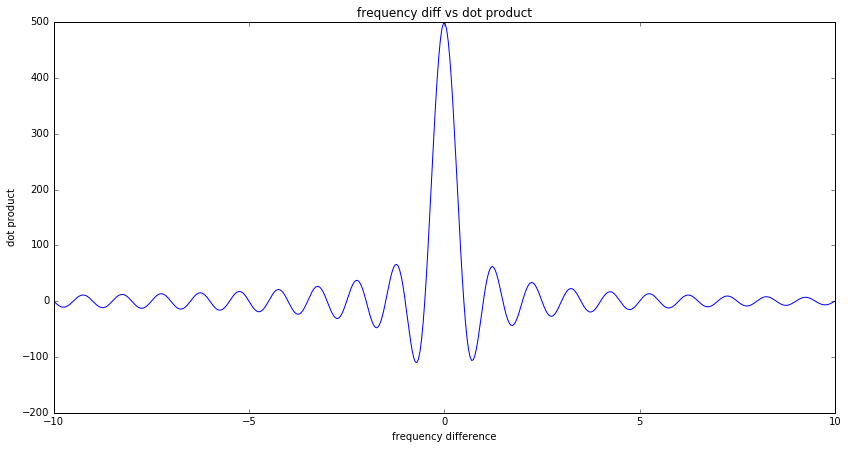

In [55]:
center_freq = 20000
frequency_diffs = np.linspace(-10, 10, 500)
dots = [dot_between_freqs(center_freq, center_freq+d) for d in frequency_diffs]
setup_graph(title='frequency diff vs dot product', x_label='frequency difference', y_label='dot product', fig_size=(14,7))
plt.plot(frequency_diffs, dots)

So it looks like the dot product varies as you move away from the center frequency purely based on absolute difference in Hz, rather than based on percentage of deviation (based on the frequency).